In [ ]:
#@title #Resource
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
import ipywidgets as widgets
import pandas as pd
import io

def fopdt(y,t,um,Km,tau):
    dydt = (-y + Km * um)/tau
    return dydt

def sopdt(x,t,um,Km,tau,zeta):
    dy2dt2 = (-2.0*zeta*tau*x[1] - x[0] + Km*um)/tau**2
    return [x[1],dy2dt2]

def sim_model(x,uf,n):
    ym = np.zeros(len(t))
    dym = np.zeros(len(t))
    for i in range(0,len(t)-1):
        ts = [t[i],t[i+1]]
        if (i-x[2]/dt) <= 0:
          um = uf[0]
        else:
          um = interpo(uf,i-x[2]/dt)
        if len(x)==4:
          y = odeint(sopdt,[ym[i],dym[i]],ts,args=(um,x[0],x[1],x[3]))
        else:
          y = odeint(fopdt,[ym[i],dym[i]],ts,args=(um,x[0],x[1]))
        ym[i+1] = y[-1,0]+(np.random.rand()-0.5)*n
        dym[i+1]= y[-1,1]
    return ym

def iden(x,uf):
    y = sim_model(x,uf,0)
    obj = sum((y-yp)**2)
    return obj/len(u)

def pid(x,model):
  uc=np.zeros(len(u))
  y=np.zeros(len(u))
  er=np.zeros(len(u))
  du=0
  y0=0
  dy0=0
  Ing =0
  Kc=x[0]
  ti=x[1]
  td = x[2]
  for i in range(1, len(u)):
    y[i] = y0
    er[i] = y_set[i] - y[i]
    Ing += er[i]
    uc[i] = Kc * (er[i] + 1/ti * Ing *dt + td*(er[i]-er[i-1])/dt)
    if (i-x[2]/dt) <= 0:
      um = uc[0]
    else:
      um = interpo(uc,i-model[2]/dt) 
    ts = [t[i-1],t[i]]
    if len(model)==4:
      y1 = odeint(sopdt,[y0,dy0],ts,args=(um,model[0],model[1],model[3]))
    else:
      y1 = odeint(fopdt,[y0,dy0],ts,args=(um,model[0],model[1]))
    y0 = y1[-1,0]
    dy0=y1[-1,1]
    du+=(uc[i]-uc[i-1])**2
  return [y,er,du,uc]

def tuing(x):
  if len(x)==2:
    x=np.append(x,0)
  [y,er,du,uc] = pid(x,Process_parameter)
  obj = sum(er**2)+du*k*float(t1.value)/1000
  return obj/len(u)

def interpo(uf,n):
  up = uf[int(np.ceil(n))]
  down =uf[int(np.floor(n))]
  um= down + (up-down)*(n-np.floor(n)) 
  return um

def eva():
  ISE=0
  idle=len(y_set)-1
  try:
    while y_set[idle]==y_set[-1]:
      idle -= 1
    p90 =idle
    p10 = idle
    while (abs(yr[p90]-y_set[-1]) >abs(y_set[-1]-y_set[idle])/10):
      p90+=1
      if abs(yr[p90]-y_set[idle])<abs(y_set[-1]-y_set[idle])/10:
        p10 = p90;
    Rise_time =t[p90]-t[p10]
    for i in range(idle,len(y_set)):
      ISE+=((y_set[i]-yr[i])**2)*dt
      if abs(yr[i]-y_set[i])>(y_set[-1]-y_set[idle])/50:
        Settling_time=t[i]-t[idle]
        if i == len(y_set)-1:
          Settling_time=-1
    Overshoot= (max(map(abs,yr))-max(map(abs,y_set)))/max(map(abs,y_set))*100
    Overshoot = max(Overshoot,0)
  except:
    Rise_time = -1
    Settling_time = -1
    Overshoot = -1
  print('Rise time : ' + str(round(Rise_time,round_num))+'\t\tSettling time : ' + str(round(Settling_time,round_num)))
  print('Overshoot : ' + str((round(Overshoot,2)))+ ' %  '+'\tISE : ' + str(round(ISE)) )

#Command
# System Identification

def si1(b):
  x0 = [k,1,1]
  print('Initial SSE Objective: ' + str(round((iden(x0,u)),round_num)))
  solution = minimize(iden,x0,u)
  global Process_parameter
  Process_parameter = solution.x
  print('Final SSE Objective: ' + str(round(iden(Process_parameter,u),round_num)))
  print('Kp: ' + str(round(Process_parameter[0], round_num)))
  print('Tau: ' + str(round(Process_parameter[1], round_num)))
  print('Delay: ' + str(round(Process_parameter[2], round_num)))
  yn=sim_model(Process_parameter,u,0)
  p1,=plt.plot(t,yp,linewidth=0.5,label='Process Output')
  p2,=plt.plot(t,u,'r--',linewidth=2,label='Process Input')
  p3,=plt.plot(t,yn,'k--',linewidth=3,label='Predicted Output')
  plt.legend(handles=[p1, p2,p3])

def si2(b):
  x0=[k,1,1,1]
  print('Initial SSE Objective: ' + str(round((iden(x0,u)),round_num)))
  solution = minimize(iden,x0,u)
  global Process_parameter
  global Process_parameter2
  Process_parameter = solution.x
  Process_parameter2 = Process_parameter
  print('Final SSE Objective: ' + str(round(iden(Process_parameter,u),round_num)))
  print('Kp: ' + str(round(Process_parameter[0], round_num)))
  print('Tau: ' + str(round(Process_parameter[1], round_num)))
  print('Delay: ' + str(round(Process_parameter[2], round_num)))
  print('Zeta: ' + str(round(Process_parameter[3], round_num)))
  yn=sim_model(Process_parameter,u,0)
  p1,=plt.plot(t,yp,linewidth=0.5,label='Process Output')
  p2,=plt.plot(t,u,'r--',linewidth=2,label='Process Input')
  p3,=plt.plot(t,yn,'k--',linewidth=3,label='Predicted Output')
  plt.legend(handles=[p1, p2,p3])

# Controller Design 
def conPI(b):
  if len(Process_parameter)==4:
    x0=[2*Process_parameter[3]*Process_parameter[1]/Process_parameter[0],2*Process_parameter[3]*Process_parameter[1]]
  else:
    x0 = [Process_parameter[1]/(Process_parameter[0]*(1+Process_parameter[2])),Process_parameter[1]+Process_parameter[2]/2]
  print('Initial SSE Objective: ' + str(round(tuing(x0),round_num)))
  bnds=[(1e-6, 10000), (1e-6, 10000)]
  global solution2
  solution2 = minimize(tuing,x0, method='TNC', bounds=bnds)
  if 'Process_parameter2' in globals():
    [y,er,du,uc]=pid([solution2.x[0],solution2.x[1],0],[Process_parameter2[0],Process_parameter2[1],Process_parameter2[2],Process_parameter2[3]])
    #[y,er,du,uc]=pid([solution2.x[0],solution2.x[1],solution2.x[2]],[1,0.9,0,0.413])
  else:
    [y,er,du,uc]=pid([solution2.x[0],solution2.x[1],0],[Process_parameter[0],Process_parameter[1],Process_parameter[2]])
  print('Final SSE Objective: ' + str(round(solution2.fun,round_num)))
  print('Kc: ' + str(round(solution2.x[0], round_num)))
  print('Ti: ' + str(round(solution2.x[1], round_num)))
  p1,=plt.plot(t, y,'k--',linewidth=3,label='Controlled Output')
  p2,=plt.plot(t,y_set,linewidth=2,label='Process Setpoint')
  p3,=plt.plot(t,uc,'r--',linewidth=2,label='Controlled Input')
  plt.legend(handles=[p1, p2,p3])
  global yr
  yr = y
  eva()

def conPID(b):
  if len(Process_parameter)==4:
    x0=[2*Process_parameter[3]*Process_parameter[1]/Process_parameter[0],2*Process_parameter[3]*Process_parameter[1],Process_parameter[1]/(2*Process_parameter[3])]
  else:
    x0 = [Process_parameter[1]/(Process_parameter[0]*(1+Process_parameter[2])),Process_parameter[1]+Process_parameter[2]/2,Process_parameter[1]*Process_parameter[2]/(2*Process_parameter[1]+Process_parameter[2])]
  print('Initial SSE Objective: ' + str(round(tuing(x0),round_num)))
  bnds=[(1e-6, 10000), (1e-6, 10000),(1e-6, 10000)]
  global solution2
  solution2 = minimize(tuing,x0, method='TNC', bounds=bnds)
  if 'Process_parameter2' in globals():
    [y,er,du,uc]=pid([solution2.x[0],solution2.x[1],solution2.x[2]],[Process_parameter2[0],Process_parameter2[1],Process_parameter2[2],Process_parameter2[3]])
    #[y,err,du,uc]=pid([solution2.x[0],solution2.x[1],solution2.x[2]],[1,0.9,0,0.413])
  else:
    [y,er,du,uc]=pid([solution2.x[0],solution2.x[1],solution2.x[2]],[Process_parameter[0],Process_parameter[1],Process_parameter[2]])
  print('Final SSE Objective: ' + str(round(solution2.fun,round_num)))
  print('Kc: ' + str(round(solution2.x[0], round_num)))
  print('Ti: ' + str(round(solution2.x[1], round_num)))
  print('Td: ' + str(round(solution2.x[2], round_num)))
  p1,=plt.plot(t, y,'k--',linewidth=3,label='Controlled Output')
  p2,=plt.plot(t,y_set,linewidth=2,label='Process Setpoint')
  p3,=plt.plot(t,uc,'r--',linewidth=2,label='Controlled Input')
  plt.legend(handles=[p1, p2,p3])
  global yr
  yr = y
  eva()

def iKc(Kc,Ti,Td):
  global yr     
  if 'Process_parameter2' in globals():
    [y,er,du,uc]=pid([Kc,Ti,Td],[Process_parameter2[0],Process_parameter2[1],Process_parameter2[2],Process_parameter2[3]])
    #[y,err,du,uc]=pid([solution2.x[0],solution2.x[1],solution2.x[2]],[1,0.9,0,0.413])
  else:
    [y,er,du,uc]=pid([Kc,Ti,Td],[Process_parameter[0],Process_parameter[1],Process_parameter[2]])
  print('Kc: ' + str(round(Kc, round_num)))
  print('Ti: ' + str(round(Ti, round_num)))
  print('Td: ' + str(round(Td, round_num)))
  p1,=plt.plot(t, y,'k--',linewidth=3,label='Controlled Output')
  p2,=plt.plot(t,y_set,linewidth=2,label='Process Setpoint')
  p3,=plt.plot(t,uc,'r--',linewidth=2,label='Controlled Input')
  plt.legend(handles=[p1, p2,p3])
  yr = y
  eva()

def iG(b):
  if len(solution2.x)==2:
    solution2.x=np.append(solution2.x,0)
  widgets.interact(iKc,
                   Kc=widgets.FloatSlider(min=0, max=3*solution2.x[0],value =solution2.x[0],step=0.01*10**(-6+len(str(int(solution2.x[0]*10**5))))),
                   Ti=widgets.FloatSlider(min=0, max=3*solution2.x[1],value =solution2.x[1],step=0.01*10**(-6+len(str(int(solution2.x[1]*10**5))))),
                   Td=widgets.FloatSlider(min=0, max=3*solution2.x[2],value =solution2.x[2],step=0.01*10**(-6+len(str(int(solution2.x[2]*10**5)))))
  )

# UI
t1=widgets.Textarea(
    value='1000',
    description='Regulation:',
)

bt0=widgets.Button(
    description='1st Order System',
    icon='check'
)
bt0.on_click(si1)

bt1=widgets.Button(
    description='2nd Order System',
    icon='check' 
)
bt1.on_click(si2)

bt2=widgets.Button(
    description='PI',
    icon='check' 
)
bt2.on_click(conPI)

bt3=widgets.Button(
    description='PID',
    icon='check' 
)
bt3.on_click(conPID)

bt4=widgets.Button(
    description='Manual Adjustment',
    icon='check' 
)
bt4.on_click(iG)

w1=widgets.HBox(
    children=(bt0,bt1,bt2,bt3),
    layout=widgets.Layout(margin='0 0 0 50px')
)

w2=widgets.HBox(
    children=(bt4,t1),
    layout=widgets.Layout(margin='0 0 0 50px')
)

w=widgets.VBox(
    children=(w1,w2),
    layout=widgets.Layout(margin='0 0 0 50px')
)

uploader = widgets.FileUpload(
    accept='',  
    multiple=False
)
display(uploader)

print("Please upload .xlsx file")


FileUpload(value={}, description='Upload')

Please upload .xlsx file


In [ ]:
#@title #Read Data 
data=uploader.value
df=pd.read_excel(io.BytesIO(data[list(data.keys())[-1]]['content']))
t=df.iloc[:,0].tolist()
u=df.iloc[:,1].tolist()
yp=df.iloc[:,2].tolist() 
#t=np.linspace(0,len(yp),len(yp))
y_set=df.iloc[:,3].tolist() 
t=np.array(t)-t[0]
u=np.array(u)-u[0]
yp=np.array(yp)-yp[0]
y_set=np.array(y_set)-y_set[0]
if u[-1]!=0:
  k = y_set[-1]/u[-1]
else:
  k=1
dt = t[1]-t[0]
if 'Process_parameter2' in globals():
  del(Process_parameter2)
round_num = 4

p1, =plt.plot(t,yp,linewidth=0.5,label='Process Output')
p2, =plt.plot(t,u,'r--',linewidth=2,label='Process Input')
plt.legend(handles=[p1, p2])


Initial SSE Objective: 0.9665
Final SSE Objective: 0.6262
Kp: 1.0031
Tau: 2.9242
Delay: 0.0


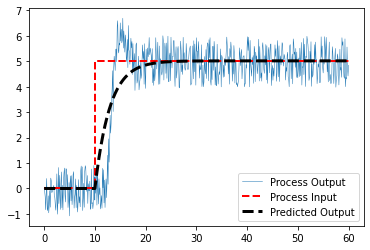

Initial SSE Objective: 0.6128
Final SSE Objective: 0.4497
Kp: 0.9841
Tau: 1.9223
Delay: 0.0
Zeta: 0.5313


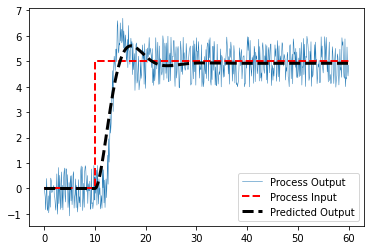

Initial SSE Objective: 1.3253
Final SSE Objective: 0.837
Kc: 1.4904
Ti: 3.8567
Rise time : 2.2		Settling time : 18.8
Overshoot : 16.92 %  	ISE : 44.0


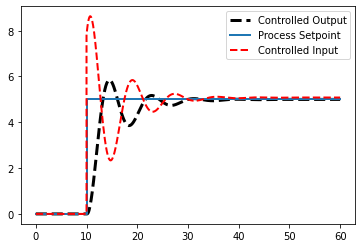

Initial SSE Objective: 124.2903
Final SSE Objective: 0.9728
Kc: 0.6449
Ti: 2.029
Td: 0.0
Rise time : 3.3		Settling time : 22.6
Overshoot : 9.98 %  	ISE : 57.0


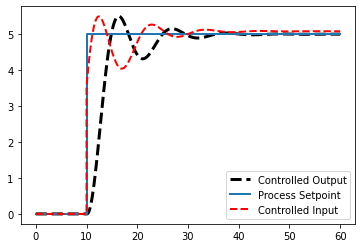

In [ ]:
#@title #Operations
display(w)


In [ ]:
#@title #I don't wanna see the MV
p1,=plt.plot(t, yr,'k--',linewidth=3,label='Controlled Output')
p2,=plt.plot(t,y_set,linewidth=2,label='Process Setpoint')
plt.legend(handles=[p1, p2])
